## Sales Forecasting 

Welcome to the **"Sales Forecasting for FMCG Stores"** GitHub repository. This project focuses on leveraging data analysis and predictive modeling to forecast sales for Fast-Moving Consumer Goods (FMCG) stores. 

Sales forecasting is a critical aspect of inventory management, ensuring that FMCG stores stock the right products in the right quantities to meet consumer demand effectively.

In this repository, you will find code and resources dedicated to helping FMCG store owners and managers optimize their inventory, reduce costs, and improve overall operational efficiency. Our approach combines data analytics, machine learning, and historical sales data to provide accurate and actionable sales predictions. 

Whether you are a small local store or a larger retail chain, these forecasting models can be customized to suit your specific needs, enabling you to make informed decisions and enhance your bottom line. 

Explore the code, documentation, and examples to get started on your journey to better sales forecasting for FMCG stores.

### Libraries

Before diving into data analysis, it's crucial to import the right Python libraries to equip yourself with the necessary tools and functions. These libraries act as the foundation for your analysis and help streamline tasks like data manipulation, visualization, and modeling.

In [1]:
# Import libraries
import io
import joblib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Snowpark 
import snowflake.snowpark
import snowflake.connector
import snowflake.snowpark.types as T
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION
from snowflake.snowpark import functions as F
from snowflake.snowpark.functions import udtf, col,sproc
from snowflake.snowpark.types import StringType, DateType, TimestampType, IntegerType, StructType, StructField, FloatType
from snowflake.snowpark.functions import dateadd, current_date

# Model Building & deployment
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import json
import pandas as pd
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

### Helper functions
Helper functions are created in our codebase to ensure that our code remains concise, efficient, and easy to maintain.  Whether it's data preprocessing, feature engineering, or any other task, our well-crafted helper functions are here to streamline the process and make our code more robust and user-friendly.

In [28]:
# Helper function that generates information required for model training
#This function uses date array from inout data to build necessary columns for model training
def date_conv(date_array):
    date_array_df = pd.DataFrame(date_array.values, columns = ['Transaction_Date'])
    date_array_df['Transaction_Date'] = pd.to_datetime(date_array_df['Transaction_Date'])
    date_array_df['day_of_year'] = date_array_df['Transaction_Date'].dt.dayofyear
    date_array_df['day_of_month'] = date_array_df['Transaction_Date'].dt.day
    date_array_df['day_of_week'] = date_array_df['Transaction_Date'].dt.dayofweek  # Monday=0, Sunday=6
    date_array_df['month'] = date_array_df['Transaction_Date'].dt.month
    date_array_df['quarter'] = date_array_df['Transaction_Date'].dt.quarter
    date_array_df['year'] = date_array_df['Transaction_Date'].dt.year
    return date_array_df

In [3]:
#Helper function that prepares data for forecasting
#Uses range of dates (start date and end date) to create a input data for forecasting UDF
def forecast_data_prep(start_date,end_date):
    forecast_start_date=pd.to_datetime(start_date)
    forecast_end_date=pd.to_datetime(end_date)
    date_array = pd.date_range(forecast_start_date,forecast_end_date, freq='D')
    forecast_data1 = date_conv(date_array).set_index('Transaction_Date')
    return forecast_data1

### Snowflake Session

In [41]:
# Create Snowflake Session object
connection_parameters = json.load(open('connection_MA.json'))
conn = Session.builder.configs(connection_parameters).create()
conn.sql_simplifier_enabled = True
snowflake_environment = conn.sql('select current_user(), current_role(), current_database(), current_schema(), current_version(), current_warehouse()').collect()
snowpark_version = VERSION
# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(snowflake_environment[0][1]))
print('Database                    : {}'.format(snowflake_environment[0][2]))
print('Schema                      : {}'.format(snowflake_environment[0][3]))
print('Warehouse                   : {}'.format(snowflake_environment[0][5]))
print('Snowflake version           : {}'.format(snowflake_environment[0][4]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

#### Add packages from snowflake - for SPROC and UDF creation

In [ ]:
conn.add_packages('snowflake-snowpark-python', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'cachetools','xgboost')

#### Reading data from snowflake database 

In [9]:
NRSF_df = conn.table('NewRetail_Sales_And_Baskets_Fact').toPandas()
NRSF_df.columns

Index(['Basket_Key', 'POS_Transaction_Number', 'Product_Key',
       'Product_Cost_Key', 'Sales_Quantity', 'Sales_Dollar_Amount',
       'Cost_Dollar_Amount', 'Gross_Profit_Dollar_Amount', 'Promotion_Key',
       'Diet_Key', 'Store_Key', 'Customer_Key', 'Transaction_Type',
       'Transaction_Date', 'Tender_Type', 'CATEGORY', 'PRODUCT_NAME'],
      dtype='object')

### Data Preparation 

To make accurate predictions, we need to get our data in order. Our data includes dates, sales_quantity, and sales_dollar_amounts. 

Under this section We're organizing data neatly, aggregating columns, and creating useful features. This preparation turns our data into a format that our forecasting models can work with effectively.

By getting our data ready, we're making sure our predictions are trustworthy, so we can make smart decisions based on them. 

In [13]:
# Aggegating column information at a Day level 

grouped_data = NRSF_df.groupby([ 'Transaction_Date']).agg({
    'Sales_Quantity': 'sum',
    'Sales_Dollar_Amount': 'sum',
    'Tender_Type':lambda x: x.value_counts().idxmax()
}).reset_index()

print(grouped_data.info())
print(grouped_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1522 entries, 0 to 1521
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Transaction_Date     1522 non-null   object 
 1   Sales_Quantity       1522 non-null   int64  
 2   Sales_Dollar_Amount  1522 non-null   float64
 3   Tender_Type          1522 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 47.7+ KB
None
  Transaction_Date  Sales_Quantity  Sales_Dollar_Amount Tender_Type
0       2013-11-01            4849             19119.95       Debit
1       2013-11-02            5043             19971.82       Other
2       2013-11-03            4714             18566.75      Credit
3       2013-11-04            4924             20281.39       Check
4       2013-11-05            5619             22153.32       Check


### Model training

In [16]:
# Categorical column 'Tender_Type' encoding using Laber encoder
encode_columns = [ 'Tender_Type']
encode_df = grouped_data[encode_columns]
encode_df = encode_df.astype('str')
encode_df = encode_df.apply(LabelEncoder().fit_transform)
# Adding the encoded column to the main table grouped_data
training_data= pd.merge(grouped_data,encode_df, left_index=True, right_index=True)
training_data=training_data.drop('Tender_Type_x', axis=1) # Dropping unwanted column 
training_data.columns=['Transaction_Date','Sales_Quantity', 'Sales_Dollar_Amount', 'Tender_Type' ]
training_data['Transaction_Date'] = pd.to_datetime(training_data['Transaction_Date'])
# Add the desired columns
training_data['day_of_year'] = training_data['Transaction_Date'].dt.dayofyear
training_data['day_of_month'] = training_data['Transaction_Date'].dt.day
training_data['day_of_week'] = training_data['Transaction_Date'].dt.dayofweek  # Monday=0, Sunday=6
training_data['month'] = training_data['Transaction_Date'].dt.month
training_data['quarter'] = training_data['Transaction_Date'].dt.quarter
training_data['year'] = training_data['Transaction_Date'].dt.year
training_data = training_data.set_index('Transaction_Date')

In [17]:
# Select features for training the model
feature_cols = ['day_of_year','day_of_month', 'day_of_week', 'month', 'quarter', 'year']
X = training_data[feature_cols]
# print(X)ar']
y_quantity = training_data['Sales_Quantity']
# print (y_quantity)


# Define the best hyperparameters obtained from hyperparameter tuning
best_params = {
    'max_depth': 6,
    'eta': 0.3,
    'gamma': 0,
    'subsample': 1
}

model_quantity = xgb.XGBRegressor(n_estimators=200, n_jobs=1,
    max_depth=best_params['max_depth'],
    eta=best_params['eta'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample']
    )
print (model_quantity)
model_quantity.fit(X, y_quantity)
feat_importance = pd.DataFrame(
        model_quantity.feature_importances_, feature_cols, columns=["FeatImportance"]
    ).to_dict() 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=1,
             num_parallel_tree=None, predictor=None, ...)


#### SPROC for Training

Stored procedure that handles all the above mentioned processes. 
- Takes the session and name of the snowflake table as input parameters 
- Performs Data manipulation, Transformation, model training 
- Saves the model to **"SNOWFLAKE STAGE"** for future use
- Gives the importances of features as output

**Note:** You need to create a snowflake stage before running this kernel

In [10]:
def xgb_train(session: Session,training_table: str,) -> T.Variant: #snowflake.snowpark.Session

    NRSF_df = session.table(training_table).toPandas()
    grouped_data = NRSF_df.groupby([ 'Transaction_Date']).agg({
        'Sales_Quantity': 'sum',
        'Sales_Dollar_Amount': 'sum',
        'Tender_Type':lambda x: x.value_counts().idxmax()
    }).reset_index()

    # from sklearn.preprocessing import LabelEncoder
    encode_columns = [ 'Tender_Type']
    encode_df = grouped_data[encode_columns]
    encode_df = encode_df.astype('str')
    encode_df = encode_df.apply(LabelEncoder().fit_transform)

    training_data= pd.merge(grouped_data,encode_df, left_index=True, right_index=True)
    training_data=training_data.drop('Tender_Type_x', axis=1) 
    training_data.columns=['Transaction_Date','Sales_Quantity', 'Sales_Dollar_Amount', 'Tender_Type' ]
        
    training_data['Transaction_Date'] = pd.to_datetime(training_data['Transaction_Date'])
    # Add the desired columns
    training_data['day_of_year'] = training_data['Transaction_Date'].dt.dayofyear
    training_data['day_of_month'] = training_data['Transaction_Date'].dt.day
    training_data['day_of_week'] = training_data['Transaction_Date'].dt.dayofweek  # Monday=0, Sunday=6
    training_data['month'] = training_data['Transaction_Date'].dt.month
    training_data['quarter'] = training_data['Transaction_Date'].dt.quarter
    training_data['year'] = training_data['Transaction_Date'].dt.year
    training_data = training_data.set_index('Transaction_Date')
    

    # models_quantity = {}  # Store models for sales quantity
    feature_cols = ['day_of_year','day_of_month', 'day_of_week', 'month', 'quarter', 'year']
    X = training_data[feature_cols]
    # print(X)ar']
    y_quantity = training_data['Sales_Quantity']
    # print (y_quantity)


    # Define the best hyperparameters obtained from hyperparameter tuning
    best_params = {
        'max_depth': 6,
        'eta': 0.3,
        'gamma': 0,
        'subsample': 1
    }

    model_quantity = xgb.XGBRegressor(n_estimators=200, n_jobs=1,
        max_depth=best_params['max_depth'],
        eta=best_params['eta'],
        gamma=best_params['gamma'],
        subsample=best_params['subsample']
        )
    print (model_quantity)
    model_quantity.fit(X, y_quantity)
    feat_importance = pd.DataFrame(
            model_quantity.feature_importances_, feature_cols, columns=["FeatImportance"]
        ).to_dict()    # save the full pipeline including the model
    

    # save_file(session, model_quantity, "@TEST_TS_STAGE/sales_forecast_model.joblib")
    joblib.dump(model_quantity,'/tmp/' + 'sales_forecast_model_new.model')

    #upload into the ML_MODELS SNowfla
    session.file.put(
        '/tmp/' + 'sales_forecast_model_new.model', "@TEST_TS_STAGE", auto_compress=False, overwrite=True
    )

    return feat_importance

#### Registering SPROC to Snowflake using Snowpark

To register the function on Snowflake as a stored procedure, specify what Python packages are required in the function. Here we specify:

Snowpark
- For training the model
Scikit-learn 
,Pandas
,Xgboost
- For creating a model file
Joblib 

Scikit-learn is a popular Python library for Machine Learning. We will be able to leverage its functionality in Snowflake in our deployed stored procedure.



In [ ]:
sproc_xgb_train = conn.sproc.register(
                    func=xgb_train, 
                    name='sproc_xgb_train', 
                    is_permanent=True, 
                    replace=True, 
                    stage_location='@TEST_TS_STAGE', 
                    packages=[
                        'snowflake-snowpark-python', 'scikit-learn', 'pandas', 'numpy', 'joblib', 'cachetools','xgboost']
)

### Training ML model using SPROC

We will now train our model on Snowflake using our stored procedure. If more memory is required, a Snowpark Optimized Warehouse could be used. In this case, a standard Snowflake warehouse is sufficient.

Documentation for Snowpark Optimized Warehouses: https://docs.snowflake.com/en/developer-guide/snowpark/python/python-snowpark-training-ml.html


##### Call the Training Stored Procedure

In [12]:
feature_cols = ['day_of_year','day_of_month', 'day_of_week', 'month', 'quarter', 'year']
model_response = sproc_xgb_train(conn,'NewRetail_Sales_And_Baskets_Fact')
print(model_response)

{
  "FeatImportance": {
    "day_of_month": 0.09523297101259232,
    "day_of_week": 0.09622401744127274,
    "day_of_year": 0.09864940494298935,
    "month": 0.46755534410476685,
    "quarter": 0,
    "year": 0.24233826994895935
  }
}


### Testing

After training our XGBoost model on time series data, we test its capabilities. This phase ensures our model's readiness to make accurate predictions, providing us with confidence in forecasting.

In [18]:
# Test Data Preparation

# Extract test data

test_start_date = '2017-10-01'
test_end_date = '2017-12-31'
test_start_date = pd.to_datetime(test_start_date)
test_end_date = pd.to_datetime(test_end_date)

test_data = training_data[(training_data.index >= test_start_date) & (training_data.index <= test_end_date)].copy()

# Feature Selection
X_test = test_data[['day_of_year','day_of_month', 'day_of_week', 'month', 'quarter', 'year']]
y_test = test_data['Sales_Quantity']

# Model Testing
predicted_quantity_test = model_quantity.predict(X_test)
test_data1 = test_data.reset_index()
test_data1['Transaction_Date'] = test_data1['Transaction_Date'].dt.date
test_data1

,Transaction_Date,Sales_Quantity,Sales_Dollar_Amount,Tender_Type,day_of_year,day_of_month,day_of_week,month,quarter,year
0,2017-10-01,5814,24008.46,2,274,1,6,10,4,2017
1,2017-10-02,5387,22378.37,3,275,2,0,10,4,2017
2,2017-10-03,5966,25199.03,4,276,3,1,10,4,2017
3,2017-10-04,5484,22422.84,0,277,4,2,10,4,2017
4,2017-10-05,5094,20251.97,0,278,5,3,10,4,2017
...,...,...,...,...,...,...,...,...,...,...
87,2017-12-27,5994,25900.18,1,361,27,2,12,4,2017
88,2017-12-28,5506,22301.79,3,362,28,3,12,4,2017
89,2017-12-29,5340,21468.78,3,363,29,4,12,4,2017
90,2017-12-30,5826,23943.52,0,364,30,5,12,4,2017


In [19]:
#Save the results to snowflake
conn.createDataFrame(test_data.reset_index()).write.save_as_table(table_name='Test_results',mode='overwrite')

#### Actual vs Predicted

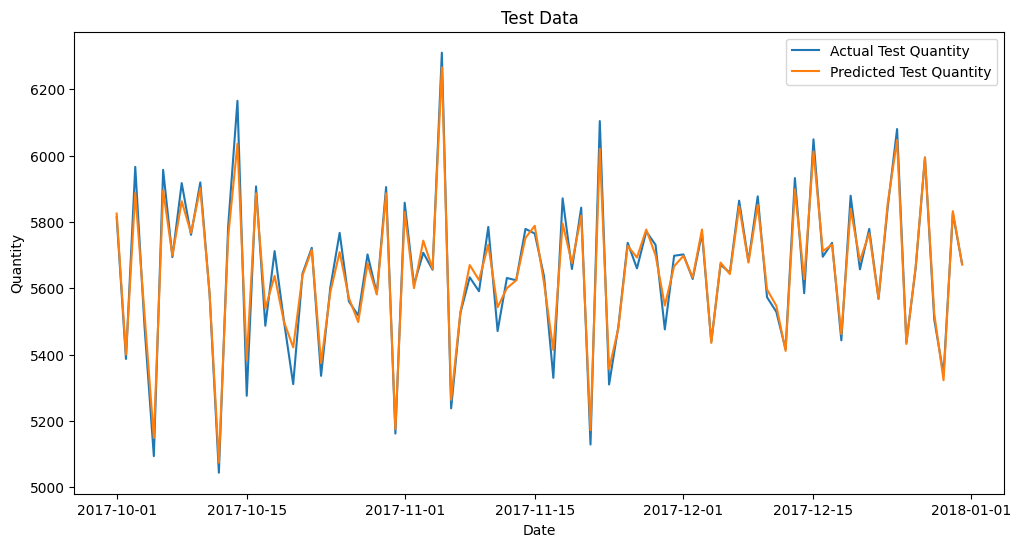

In [43]:
test_data['yhat'] = predicted_quantity_test

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Sales_Quantity'], label='Actual Test Quantity')
plt.plot(test_data.index, predicted_quantity_test, label='Predicted Test Quantity')

plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Test Data')
plt.legend()
plt.show()

Our model's predictions closely match the actual values, highlighting its remarkable accuracy. This alignment between expectation and reality assures the reliability of our forecasting.

In [49]:
act_pred_df = test_data[['Sales_Quantity','yhat']]
act_pred_df.columns = ['Actual Sales Quantity','Predicted Sales Quantity']
act_pred_df

,Actual Sales Quantity,Predicted Sales Quantity
Transaction_Date,,
2017-10-01,5814,5825.206055
2017-10-02,5387,5400.099609
2017-10-03,5966,5887.940918
2017-10-04,5484,5521.273438
2017-10-05,5094,5148.639648
...,...,...
2017-12-27,5994,5994.370117
2017-12-28,5506,5523.297363
2017-12-29,5340,5322.795410


We evaluate our model using Root-Mean-Square Error (RMSE) for our test data.

In [21]:
#MSE for Test Data

rmse = np.sqrt(mean_squared_error(test_data["Sales_Quantity"], predicted_quantity_test))

print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 38.769342586370364


#### UDF for Sales Forecast

Creating a user-defined function to get Forecast sales.

In [22]:
def udf_sales_forecast(*args) -> float:
    import os
    import sys
    from joblib import load
    
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'sales_forecast_model_new.model'
    model = load(import_dir+model_name)
    
    #unlike previous JSON object, this will be a array, hence no need to
    # decode the input
    # scored_data = model.predict(pd.DataFrame([args]))[0]
    scored_data = model.predict(pd.DataFrame([args], columns=feature_cols))[0]

    return scored_data

#### Register UDF to Snowflake to run forecast

In [ ]:
feature_cols = ['day_of_year','day_of_month', 'day_of_week', 'month', 'quarter', 'year']
udf_sales_forecast_res = conn.udf.register(
                            func=udf_sales_forecast, 
                            name="udf_sales_forecast_res", 
                            stage_location='@TEST_TS_STAGE',
                            input_types=[IntegerType()]*len(feature_cols),
                            return_type = FloatType(),
                            replace=True, 
                            is_permanent=True, 
                            imports=['@TEST_TS_STAGE/sales_forecast_model_new.model'],
                            packages=['scikit-learn','pandas','joblib','xgboost'], 
                            session=conn
)

#### Data Prep for forecast

Preparing data is like getting ready for a journey. We clean, organize, and structure our data so that our forecasting models can understand it. This crucial step ensures our predictions are accurate and reliable, helping us make informed decisions.

In [30]:
# Forecasting sales for one month 
forecast_start_date = '2017-12-31'
forecast_end_date = '2018-01-31'
forecast_start_date=pd.to_datetime(forecast_start_date)
forecast_end_date=pd.to_datetime(forecast_end_date)
date_array = pd.date_range(forecast_start_date,forecast_end_date, freq='D')
forecast_data1 = date_conv(date_array).set_index('Transaction_Date')
forecast_data1.head()

,day_of_year,day_of_month,day_of_week,month,quarter,year
Transaction_Date,,,,,,
2017-12-31,365,31,6,12,4,2017
2018-01-01,1,1,0,1,1,2018
2018-01-02,2,2,1,1,1,2018
2018-01-03,3,3,2,1,1,2018
2018-01-04,4,4,3,1,1,2018


- After the model training phase, we apply the Forecast UDF to make both short-term (1 month) and mid-term (6 months) forecasts. 
- These forecasts provide valuable insights for decision-making, enabling us to plan effectively and respond to changing conditions with confidence. 

In [31]:
#Forecast using snowpark UDF
inputs = conn.create_dataframe(forecast_data1)
print(inputs.show())
res=conn.create_dataframe(forecast_data1).select(*inputs,#'day_of_year', 'day_of_month', 'day_of_week', 'month', 'quarter', 'year',
                                                  udf_sales_forecast_res(*inputs)
                                                  .alias('Prediction'))
res_df = res.to_pandas().sort_values(by=['day_of_year','day_of_month']).reset_index().drop('index',axis=1)
res_df['Transaction_Date'] = date_array
res_df['Transaction_Date'] = res_df['Transaction_Date'].dt.date
res_df.head()

---------------------------------------------------------------------------------
|"day_of_year"  |"day_of_month"  |"day_of_week"  |"month"  |"quarter"  |"year"  |
---------------------------------------------------------------------------------
|365            |31              |6              |12       |4          |2017    |
|1              |1               |0              |1        |1          |2018    |
|2              |2               |1              |1        |1          |2018    |
|3              |3               |2              |1        |1          |2018    |
|4              |4               |3              |1        |1          |2018    |
|5              |5               |4              |1        |1          |2018    |
|6              |6               |5              |1        |1          |2018    |
|7              |7               |6              |1        |1          |2018    |
|8              |8               |0              |1        |1          |2018    |
|9              

,day_of_year,day_of_month,day_of_week,month,quarter,year,PREDICTION,Transaction_Date
0,1,1,0,1,1,2018,5712.647949,2017-12-31
1,2,2,1,1,1,2018,5605.336914,2018-01-01
2,3,3,2,1,1,2018,5495.951660,2018-01-02
3,4,4,3,1,1,2018,5291.821777,2018-01-03
4,5,5,4,1,1,2018,5420.416504,2018-01-04


In [32]:
# Upload results to snowflake 
conn.createDataFrame(res_df).write.save_as_table(table_name='Forecast_results',mode='overwrite')

**Forecast for one month**

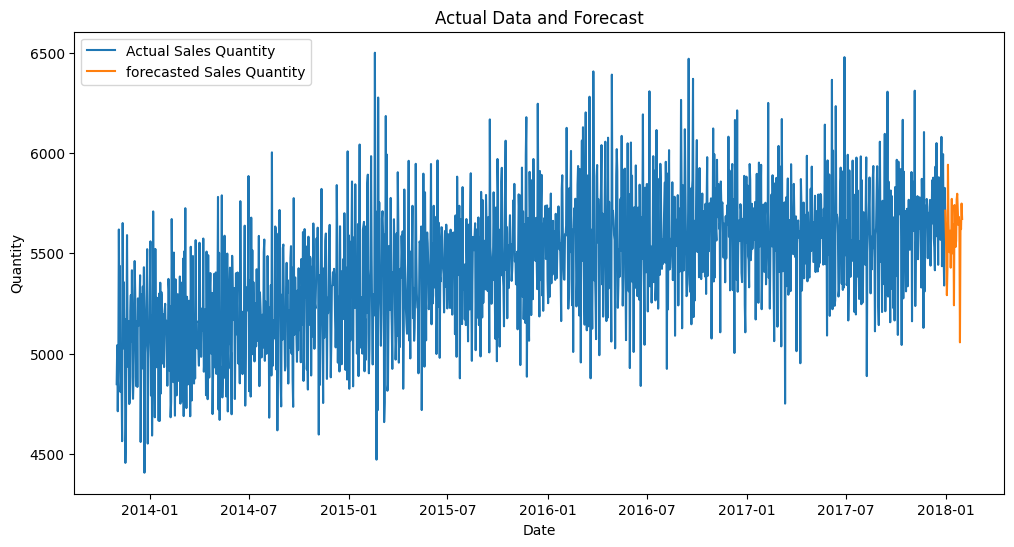

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(training_data.index, training_data['Sales_Quantity'], label='Actual Sales Quantity')
plt.plot(res_df['Transaction_Date'], res_df['PREDICTION'], label='forecasted Sales Quantity')
# plt.plot(forecast_dates, forecasted_quantity, label='Forecasted Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual Data and Forecast')
plt.legend()
plt.show()

In [33]:
def forecast_data_prep(start_date,end_date):
    forecast_start_date=pd.to_datetime(start_date)
    forecast_end_date=pd.to_datetime(end_date)
    date_array = pd.date_range(forecast_start_date,forecast_end_date, freq='D')
    forecast_data1 = date_conv(date_array).set_index('Transaction_Date')
    return forecast_data1

**Forecast for 6 months**

In [34]:
# 6 month Sales Forecast
start_date,end_date = '2018-01-01','2018-06-30'
date_input = forecast_data_prep(start_date,end_date)
# print(date_input)
inputs_forecast = conn.create_dataframe(date_input)
# cols_list=date_input.columns.to_list()
print(inputs_forecast.show())
res1=conn.create_dataframe(date_input).select(*inputs_forecast,#'day_of_year', 'day_of_month', 'day_of_week', 'month', 'quarter', 'year',
                                                  udf_sales_forecast_res(*inputs_forecast)
                                                  .alias('Prediction'))
res1_df = res1.to_pandas()
date_array1 = pd.date_range(start_date,end_date, freq='D')
res1_df = res1_df.sort_values(by=['day_of_year','day_of_month']).reset_index().drop('index',axis=1)
res1_df['Transaction_Date'] = pd.to_datetime(date_array1)
res1_df['Transaction_Date']=res1_df['Transaction_Date'].dt.date
res1_df.head()

---------------------------------------------------------------------------------
|"day_of_year"  |"day_of_month"  |"day_of_week"  |"month"  |"quarter"  |"year"  |
---------------------------------------------------------------------------------
|1              |1               |0              |1        |1          |2018    |
|2              |2               |1              |1        |1          |2018    |
|3              |3               |2              |1        |1          |2018    |
|4              |4               |3              |1        |1          |2018    |
|5              |5               |4              |1        |1          |2018    |
|6              |6               |5              |1        |1          |2018    |
|7              |7               |6              |1        |1          |2018    |
|8              |8               |0              |1        |1          |2018    |
|9              |9               |1              |1        |1          |2018    |
|10             

,day_of_year,day_of_month,day_of_week,month,quarter,year,PREDICTION,Transaction_Date
0,1,1,0,1,1,2018,5712.647949,2018-01-01
1,2,2,1,1,1,2018,5605.336914,2018-01-02
2,3,3,2,1,1,2018,5495.951660,2018-01-03
3,4,4,3,1,1,2018,5291.821777,2018-01-04
4,5,5,4,1,1,2018,5420.416504,2018-01-05


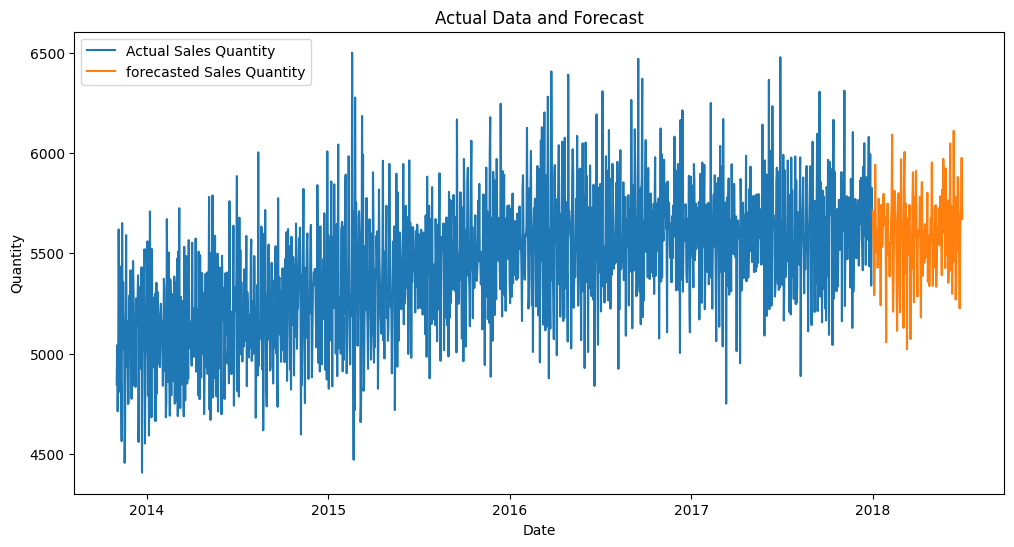

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(training_data.index, training_data['Sales_Quantity'], label='Actual Sales Quantity')
plt.plot(res1_df['Transaction_Date'], res1_df['PREDICTION'], label='forecasted Sales Quantity')
# plt.plot(forecast_dates, forecasted_quantity, label='Forecasted Quantity')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Actual Data and Forecast')
plt.legend()
plt.show()

#### Upload the results to Snowflake table

In [35]:
conn.createDataFrame(res1_df).write.save_as_table(table_name='Forecast_results_6months',mode='overwrite')